# Discovery of Non-Linear Pendulum Dynamics using SODAs


This notebook documents the process of discovering the equations of motion of a  non-linear pendulum (away from small angle approximations) from pixel data of a video footage of an experimen where a singel pendulum which is part of newton's craddle is swingin from different initial conditions. The footage was shot on an Iphone 16pro with 120 fps.  

## Workflow
1. **Loading Video Footage**: The video footage of the pendulum is loaded using `cv2`, an open-source computer vision package in Python.
2. **Tracking the Pendulum Bob**: The x and y coordinates of the pendulum bob are tracked. The pivot point is centered at the origin.
3. **Normalization**: The length of the pendulum is normalized to be 1.
4. **Data Processing**: SODAs is applied to the (x,y) coordinates to find the algebraic constraints in the system using.
5. **Equation Discovery**: After the coordinat system is discovered, we transition into polar coordinates where the appropriate library functions are craeted to discover the polar equation of the pendulum.

## Details of the Animation
- **Numerical Method**: Runge-Kutta adaptive method
- **Initial Time Step**: 0.0025
- **Damping**: 0.5
- **Frame Rate**: 60 Hz (recorded using QuickTime Player which supports 60 fps recording)

## Workflow
1. **Loading Video Footage**: The video footage of the pendulum is loaded using `cv2`, an open-source computer vision package in Python.
2. **Tracking the Pendulum Bob**: The x and y coordinates of the pendulum bob are tracked. The pivot point is centered at the origin.
3. **Normalization**: The length of the pendulum is normalized to be 1.
4. **Data Processing**: SODAs is applied to the (x,y) coordinates to find the algebraic constraints in the system using.
5. **Equation Discovery**: After the coordinat system is discovered, we transition into polar coordinates where the appropriate library functions are craeted to discover the polar equation of the pendulum.

In [1]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))


import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import sympy
from dae_finder import construct_reduced_fit_list

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp




from matplotlib import pyplot as plt
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from dae_finder import get_simplified_equation_list
from dae_finder import get_refined_lib, remove_paranth_from_feat
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder
from dae_finder import PolyFeatureMatrix
from copy import deepcopy



/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder


## Loading data

In [2]:

# Loading pendulum data
df_list = []
index_list = [4,8,9]
for ind in index_list:
    file_path = f"data/pendulum_recording_{ind}.csv"
    df = pd.read_csv(file_path)
    df_list.append(df)

trimming_slices=  [(100,400), (100,400), (100,400), (100,400), (50,400)] #for finding the dynamic equation

# trimming_slices=  [(50,300), (50,300), (50,300), (100,400), (50,400)]


df_trimmed = []
for df_, slice in zip(df_list, trimming_slices):
    df_trimmed.append(df_[slice[0]:slice[1]].reset_index(drop=True))

#centering the hook of pendulum to origin
center_dict = {4:((1578+1589)/2, (56+319)/2), 6:  ((903+906)/2, (45+150)/2)}
center_dict[7] = ((1126+1122)/2, (2+128)/2)
center_dict[8] = ((993+990)/2, (44+165)/2)
center_dict[9] = ((993+990)/2, (44+165)/2)
center_dict[10] = ((962+965)/2, (44+176)/2)
# center = ((1578+1589)/2, (56+319)/2) # 4
# center = ((903+906)/2, (45+150)/2) #6
color = [120, 255, 243]
for ind, df_ in zip(index_list, df_trimmed):
    df_["x"] = df_["X"] - center_dict[ind][0]
    df_["y"] = -(df_["Y"] - center_dict[ind][1])

# for i, df in enumerate(df_trimmed):
#     df.to_csv(f"data/trimmed_pendulum_time_series_damped_{i+1}.csv", index=False)

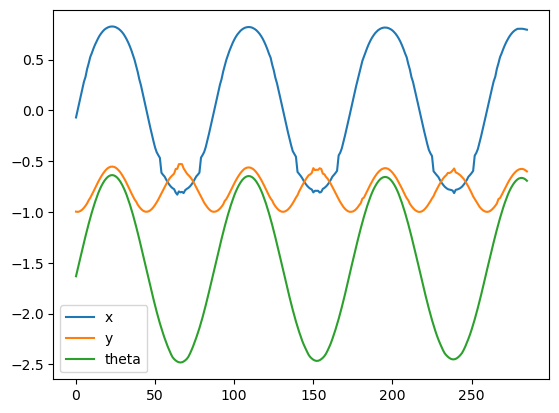

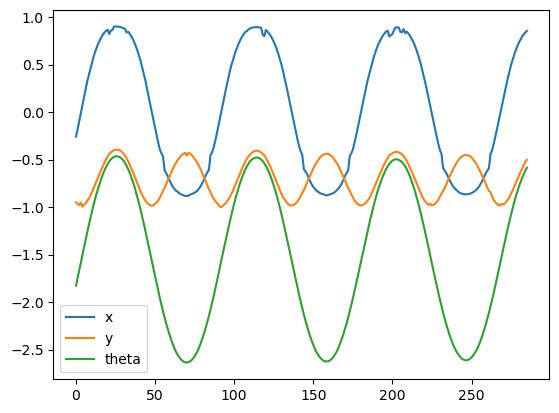

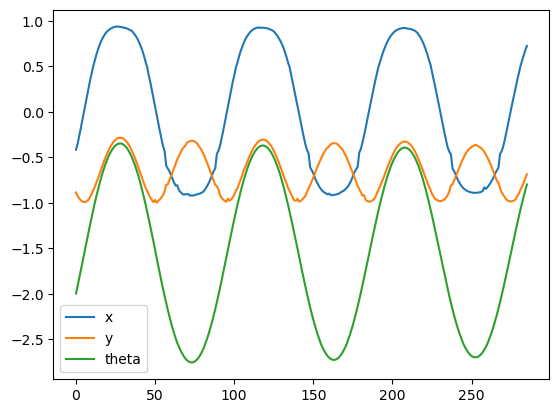

In [3]:
L=1    
smoothening_window_size = 15
#Scaling the pendulum length to L
for df_ in df_trimmed:

    # df_["x"] = df_["x"].rolling(window=smoothening_window_size, center=True).mean()
    # df_["y"] = df_["y"].rolling(window=smoothening_window_size, center=True).mean()

    pen_orig_len = abs(df_["y"]).max()
    df_["x"] = (df_["x"]/pen_orig_len) * L
    df_["y"] = (df_["y"]/pen_orig_len) * L

    # df_["theta"] = np.arctan2(df_["y"], df_["x"])
    df_["theta"] = (np.arctan2(df_["y"], df_["x"])).rolling(window=smoothening_window_size, center=True).mean()
    df_.dropna(ignore_index=True, inplace=True)

df_appended = pd.concat(df_trimmed, ignore_index=True)

for df_ in df_trimmed:
    df_[["x", "y", "theta"]].plot()


<Axes: >

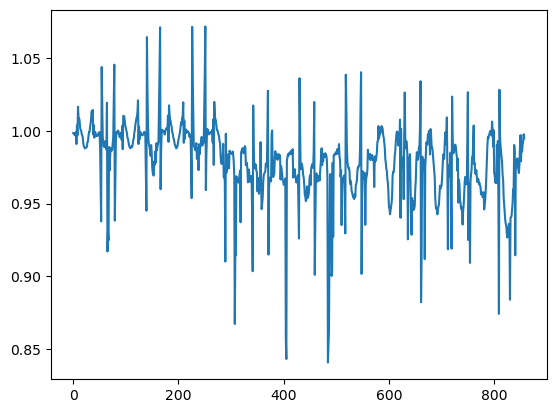

In [4]:
#Visualizing the algebraic constrain in the system
(df_appended["x"]**2+df_appended["y"]**2).plot()


### Finding the first and second order derivative of the states using Savitzky-Golay Filer

In [5]:
# Finding the first and second order derivative of the states using Savitzky-Golay Filer

data_matrix_smooth_df_list = [
    smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=2,
                polyorder=2,
                window_smooth=None)[20:-150] #trimming zero derivatives near end points
    for data_matrix in df_trimmed]



if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_new= data_matrix_df_smooth_appended[["theta", "d(theta) /dt"]]


data_matrix_df_new = data_matrix_df_new.rename(columns= dict(zip(data_matrix_df_new, ['theta', 'theta_dot'])))

## Fomring the candidate library

In [6]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))

poly_degree = 3
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

#Optionally removing features from the library
terms_to_drop_corr = set()
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))

#Adding sin and cos terms using x and y
candidate_lib_full["cos(theta)"] = data_matrix_df_smooth_appended["x"]
candidate_lib_full["sin(theta)"] = data_matrix_df_smooth_appended["y"]

/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder
Degree of library: 3
# terms in the library: 9
Full candidate library has the following features: Index(['theta', 'theta_dot', 'theta^2', 'theta theta_dot', 'theta_dot^2',
       'theta^3', 'theta^2 theta_dot', 'theta theta_dot^2', 'theta_dot^3'],
      dtype='object')


In [7]:
# candidate_lib_full["sin(theta)"] = np.sin(candidate_lib_full["theta"])
# candidate_lib_full["cos(theta)"] = np.cos(candidate_lib_full["theta"])


# candidate_lib_full["x"] = df_trimmed[0][100:-100]["x"].reset_index(drop=True)
# candidate_lib_full["y"] = df_trimmed[0][100:-100]["y"].reset_index(drop=True)


<Axes: >

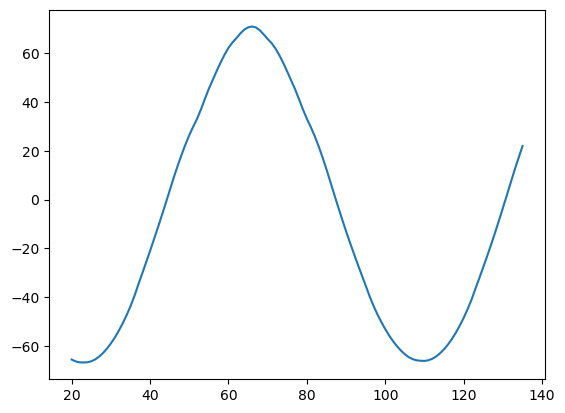

In [8]:
data_matrix_smooth_df_list[0]['d^2(theta) /dt^2'].plot()

In [9]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler with mean=False to keep the mean the same
scaler = StandardScaler(with_std=True, with_mean=False)

# Scale candidate_lib_full
candidate_lib_full_scaled = pd.DataFrame(scaler.fit_transform(candidate_lib_full), columns=candidate_lib_full.columns)

# Scale data_matrix_df_smooth_appended
data_matrix_df_smooth_appended_scaled = pd.DataFrame(scaler.fit_transform(data_matrix_df_smooth_appended), columns=data_matrix_df_smooth_appended.columns)



In [10]:
seq_th_model = sequentialThLin(model_id="lasso" ,fit_intercept=True, alpha=0.002, coef_threshold= 0.06)
# seq_th_model = sequentialThLin(model_id="lasso" ,fit_intercept=True, alpha=0.001, coef_threshold= 0.01)

# seq_th_model = sequentialThLin(fit_intercept=True, model_id="LR", coef_threshold= 0.05)

down_size = 1
X_downsampled = candidate_lib_full_scaled.iloc[::down_size, :].reset_index(drop=True)
y_downsampled = data_matrix_df_smooth_appended_scaled['d^2(theta) /dt^2'].iloc[::down_size].reset_index(drop=True)

seq_th_model.fit(X=X_downsampled, y=y_downsampled)
seq_th_model.score(X=X_downsampled, y=y_downsampled)
# data_matrix_df_smooth_appended["energy"] = 0.5*((data_matrix_df_smooth_appended["x_dot"])**2 + (data_matrix_df_smooth_appended["y_dot"])**2) +  9.81*data_matrix_df_smooth_appended["y"]
# smoothen_index = abs(data_matrix_df_smooth_appended["energy"]-data_matrix_df_smooth_appended["energy"].mean()) < 0.5*data_matrix_df_smooth_appended["energy"].std()
# seq_th_model.fit(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

# seq_th_model.score(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

Sequential threshold converged in 1 iterations


0.9993841747128137

In [11]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'theta': -0.3682137524687175,
 'theta_dot': 0.0,
 'theta^2': 0.0,
 'theta theta_dot': 0.0,
 'theta_dot^2': 0.0,
 'theta^3': 0.0,
 'theta^2 theta_dot': 0.0,
 'theta theta_dot^2': 0.0,
 'theta_dot^3': 0.0,
 'cos(theta)': -0.6302312540234349,
 'sin(theta)': 0.0}

In [12]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=X_downsampled[["cos(theta)", "theta", "theta_dot"]], y=y_downsampled)
lin_model.score(X=X_downsampled[["cos(theta)","theta", "theta_dot"]], y=y_downsampled)

0.9994027003150946

In [13]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'cos(theta)': -0.645701575120882,
 'theta': -0.35494552495398274,
 'theta_dot': -0.003768184999093017}

In [14]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=X_downsampled[["cos(theta)", "theta"]], y=y_downsampled)
lin_model.score(X=X_downsampled[["cos(theta)","theta"]], y=y_downsampled)

0.9993886770654679

In [15]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'cos(theta)': -0.6411578241375312, 'theta': -0.3592590885076301}

In [16]:

df_new_0 = df_trimmed[0][(df_trimmed[0]['x'].diff().abs() < 0.1) & (df_trimmed[0]['y'].diff().abs() < 0.1)][["t", "theta"]]
df_new_0 = df_new_0[19:]
omega0_0 = data_matrix_smooth_df_list[0]["d(theta) /dt"].iloc[0]

df_new_1 = df_trimmed[1][(df_trimmed[1]['x'].diff().abs() < 0.1) & (df_trimmed[1]['y'].diff().abs() < 0.1)][["t", "theta"]]
df_new_1 = df_new_1[19:]
omega0_1 = data_matrix_smooth_df_list[1]["d(theta) /dt"].iloc[0]


df_new_2 = df_trimmed[2][(df_trimmed[2]['x'].diff().abs() < 0.1) & (df_trimmed[2]['y'].diff().abs() < 0.1)][["t", "theta"]]
df_new_2 = df_new_2[19:]
omega0_2 = data_matrix_smooth_df_list[2]["d(theta) /dt"].iloc[0]


In [17]:
omega0_0, omega0_1, omega0_2

(1.5270948229951304, 3.313872091695751, 4.839572217284557)

In [19]:
from scipy.optimize import curve_fit


# Define the pendulum ODE function
def pendulum_rhs(t, y, beta, gamma, L=1):
    theta, omega = y
    alpha = beta * np.cos(theta) + gamma * theta
    return [omega, alpha]

# Define the pendulum ODE function for curve fitting
def pendulum_ode_combined(t, beta, gamma):
    # Initial conditions for each dataset
    initial_conditions = [
        (df_new_0['theta'].iloc[0], omega0_0),
        (df_new_1['theta'].iloc[0], omega0_1),
        (df_new_2['theta'].iloc[0], omega0_2)
    ]
    
    # Time values for each dataset
    t_values_list = [df_new_0['t'].values, df_new_1['t'].values, df_new_2['t'].values]
    
    # Solve the ODE for each dataset and concatenate the results
    theta_values_combined = []
    for (theta0, omega0), t_values in zip(initial_conditions, t_values_list):
        y0 = [theta0, omega0]
        sol = solve_ivp(pendulum_rhs, [t_values[0], t_values[-1]], y0, t_eval=t_values, args=(beta, gamma))
        theta_values_combined.extend(sol.y[0])
    
    return np.array(theta_values_combined)

# Combine the theta values from all datasets
theta_values_combined = np.concatenate([df_new_0['theta'].values, df_new_1['theta'].values, df_new_2['theta'].values])

# Combine the time values from all datasets
t_values_combined = np.concatenate([df_new_0['t'].values, df_new_1['t'].values, df_new_2['t'].values])

# Define initial guesses for beta and gamma
initial_guesses = [
    [-6.5, -3],
    [-10, -5],
    [-5, -2],
    [-8, -4],
    [-10, -10],
    [-5, 0],
    [0, -5],
    [5, 5],
    [10, 10],
    [15, -15],
    [-20, 20],
    [25, -25],
    [-30, 30],
    [-100,0],
    [0,-100]
]

best_params = None
best_rss = np.inf

# Perform curve fitting with different initial guesses
for initial_guess in initial_guesses:
    params, params_covariance = curve_fit(pendulum_ode_combined, t_values_combined, theta_values_combined, p0=initial_guess, maxfev=1000)
    beta_est, gamma_est = params
    
    # Calculate the residual sum of squares (RSS)
    theta_fitted = pendulum_ode_combined(t_values_combined, beta_est, gamma_est)
    rss = np.sum((theta_values_combined - theta_fitted) ** 2)
    
    # Update the best parameters if the current RSS is lower
    if rss < best_rss:
        best_rss = rss
        best_params = params

beta_est, gamma_est = best_params
print(f"Best estimated beta: {beta_est}")
print(f"Best estimated gamma: {gamma_est}")
print(f"Best RSS: {best_rss}")

Best estimated beta: -82.9811497389859
Best estimated gamma: -0.7967016088688774
Best RSS: 0.5612958619319421


In [419]:
# from scipy.integrate import solve_ivp
# import matplotlib.pyplot as plt

# # Define the pendulum ODE function using the optimized parameters
# def pendulum_rhs(t, y, beta, gamma, L=1):
#     theta, omega = y
#     alpha = beta * np.cos(theta) + gamma * theta
#     return [omega, alpha]

# # Function to plot actual vs simulated theta for a given dataset
# def plot_actual_vs_simulated(df_new, omega0, beta_est, gamma_est, title):
#     t_values = df_new['t'].values
#     theta_values = df_new['theta'].values

#     # Initial conditions: theta(0) and omega(0)
#     theta0 = theta_values[0]
#     y0 = [theta0, omega0]

#     # Solve the ODE using the optimized parameters
#     sol = solve_ivp(pendulum_rhs, [t_values[0], t_values[-1]], y0, t_eval=t_values, args=(beta_est, gamma_est))

#     # Plot the results
#     plt.figure(figsize=(10, 6))
#     plt.plot(t_values, theta_values, label='Actual Theta', color='blue')
#     plt.plot(t_values, sol.y[0], label='Simulated Theta', color='red', linestyle='--')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Theta (radians)')
#     plt.title(title)
#     plt.legend()
#     plt.show()

# # Plot for df_new_0
# plot_actual_vs_simulated(df_new_0, omega0_0, beta_est, gamma_est, 'Actual vs Simulated Theta for df_new_0')

# # Plot for df_new_1
# plot_actual_vs_simulated(df_new_1, omega0_1, beta_est, gamma_est, 'Actual vs Simulated Theta for df_new_1')

# # Plot for df_new_2
# plot_actual_vs_simulated(df_new_2, omega0_2, beta_est, gamma_est, 'Actual vs Simulated Theta for df_new_2')

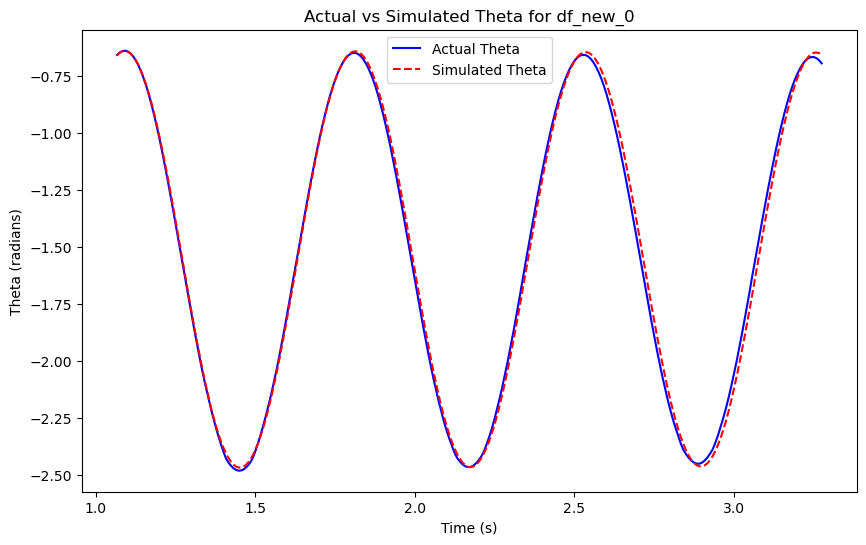

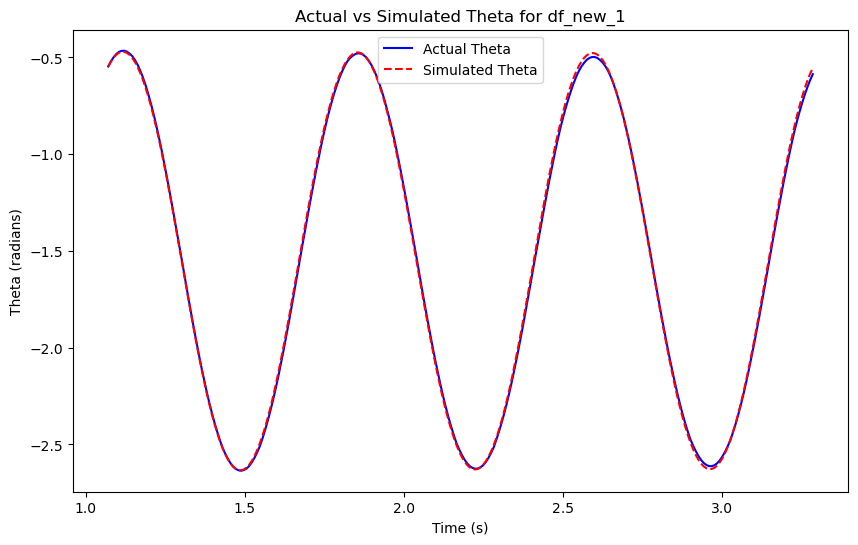

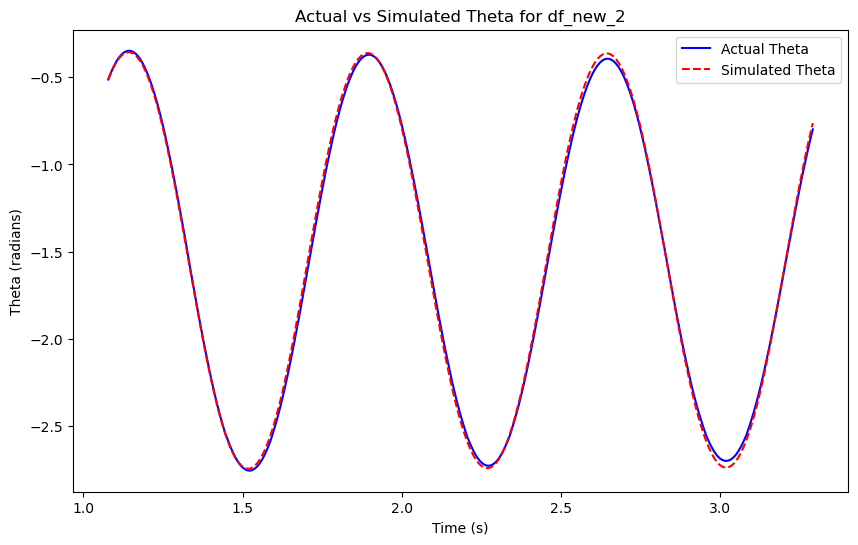

In [20]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the pendulum ODE function using the optimized parameters
def pendulum_rhs(t, y, beta, gamma, L=1):
    theta, omega = y
    alpha = beta * np.cos(theta) + gamma * theta
    return [omega, alpha]

# Function to plot actual vs simulated theta for a given dataset
def plot_actual_vs_simulated(df_new, omega0, beta_est, gamma_est, title):
    t_values = df_new['t'].values
    theta_values = df_new['theta'].values

    # Initial conditions: theta(0) and omega(0)
    theta0 = theta_values[0]
    y0 = [theta0, omega0]

    # Solve the ODE using the optimized parameters
    sol = solve_ivp(pendulum_rhs, [t_values[0], t_values[-1]], y0, t_eval=t_values, args=(beta_est, gamma_est))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(t_values, theta_values, label='Actual Theta', color='blue')
    plt.plot(t_values, sol.y[0], label='Simulated Theta', color='red', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Theta (radians)')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot for df_new_0
plot_actual_vs_simulated(df_new_0, omega0_0, beta_est, gamma_est, 'Actual vs Simulated Theta for df_new_0')

# Plot for df_new_1
plot_actual_vs_simulated(df_new_1, omega0_1, beta_est, gamma_est, 'Actual vs Simulated Theta for df_new_1')

# Plot for df_new_2
plot_actual_vs_simulated(df_new_2, omega0_2, beta_est, gamma_est, 'Actual vs Simulated Theta for df_new_2')

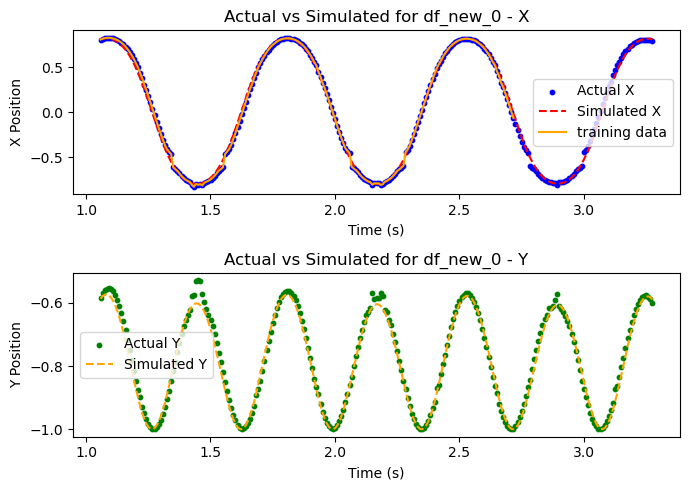

In [21]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def pendulum_rhs(t, y, beta, gamma, L=1):
    theta, omega = y
    alpha = beta * np.cos(theta) + gamma * theta
    return [omega, alpha]
def plot_actual_vs_simulated(df_new, omega0, beta_est, gamma_est, title, training_num=200):
    t_values = df_new['t'].values
    x_values = df_new['x'].values
    y_values = df_new['y'].values

    theta0 = np.arctan2(y_values[0], x_values[0])
    y0 = [theta0, omega0]

    sol = solve_ivp(pendulum_rhs, [t_values[0], t_values[-1]], y0, t_eval=t_values, args=(beta_est, gamma_est))

    theta_simulated = sol.y[0]
    x_simulated = L * np.cos(theta_simulated)
    y_simulated = L * np.sin(theta_simulated)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))

    ax1.scatter(t_values, x_values, label='Actual X', color='blue', s=10)
    ax1.plot(t_values, x_simulated, label='Simulated X', color='red', linestyle='--')
    ax1.plot(t_values[:training_num], x_values[:training_num], label='training data', color='orange')

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('X Position')
    ax1.set_title(f'{title} - X')
    ax1.legend()

    ax2.scatter(t_values, y_values, label='Actual Y', color='green', s=10)
    ax2.plot(t_values, y_simulated, label='Simulated Y', color='orange', linestyle='--')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Y Position')
    ax2.set_title(f'{title} - Y')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Plot for df_new_0
plot_actual_vs_simulated(df_trimmed[0][19:], omega0_0, beta_est, gamma_est, 'Actual vs Simulated for df_new_0')

# # Plot for df_new_1
# plot_actual_vs_simulated(df_trimmed[1][19:], omega0_1, beta_est, gamma_est, 'Actual vs Simulated for df_new_1')

# # Plot for df_new_2
# plot_actual_vs_simulated(df_trimmed[2][19:], omega0_2, beta_est, gamma_est, 'Actual vs Simulated for df_new_2')


In [127]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=candidate_lib_full[["cos(theta)"]], y=data_matrix_df_smooth_appended_scaled['d^2(theta) /dt^2'])
lin_model.score(X=candidate_lib_full[["cos(theta)"]], y=data_matrix_df_smooth_appended_scaled['d^2(theta) /dt^2'])

0.9981543434230811

In [96]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'cos(theta)': -1.4429552811903108}

## Finding minimum number of data points required

In [99]:
poly_degree = 3
from daeFinder import sequentialThLin
from daeFinder import AlgModelFinder
from daeFinder import remove_paranth_from_feat
# Adding the state variables as scipy symbols

In [100]:
for ind in range(len(df_trimmed)):
    df_trimmed[ind] = df_trimmed[ind][(df_trimmed[ind]['x'].diff().abs() < 0.1) & (df_trimmed[ind]['y'].diff().abs() < 0.1)]
    # df_trimmed[ind] = df_trimmed[ind].sample(frac=1).reset_index(drop=True)

df_appended = pd.concat(df_trimmed).sample(frac=1).reset_index(drop=True)

In [101]:
best_relationship_dict = {}
for num_points in range(50,1000,50):
    # data_matrix_df_new = pd.concat([df_[:num_points][["x","y"]] for df_ in df_trimmed])
    # data_matrix_df_new["Y"] = -data_matrix_df_new["Y"]
    data_matrix_df_new = df_appended[["x","y"]][:num_points]


    from daeFinder import PolyFeatureMatrix
    poly_feature_ob = PolyFeatureMatrix(poly_degree)
    candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
    # candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





    candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
    print("Degree of library: {}".format(poly_degree))
    print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

    #Optionally removing features from the library
    terms_to_drop_corr = set()
    candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
    print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))


    # feat_list = list(data_matrix_df_smooth_appended.columns)
    feat_list = ["x","y", "theta", "theta_dot"]
    feat_list_str = ", ".join(remove_paranth_from_feat(feat_list))
    exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")


    down_size = 1
    candidate_lib_downsized = candidate_lib_full.iloc[::down_size, :].reset_index(drop=True)


    # seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
    seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.06)

    # seq_th_model = sequentialThLin(model_id="LR", coef_threshold= 0.2)

    algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

    algebraic_model_th.fit(candidate_lib_downsized, scale_columns= True)
    best_lhs = algebraic_model_th.best_models(1).columns[0]
    best_rhs = list((algebraic_model_th.best_models(1)[best_lhs][abs(algebraic_model_th.best_models(1)[best_lhs])>0.001]).index)
    best_relationship_dict[num_points] = (best_lhs, best_rhs)


Degree of library: 3
# terms in the library: 9
Full candidate library has the following features: Index(['x', 'y', 'x^2', 'x y', 'y^2', 'x^3', 'x^2 y', 'x y^2', 'y^3'], dtype='object')
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 0 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Degree of library: 3
# terms in the library: 9
Full candidate library has the following features: Index(['x', 'y', 'x^2', 'x y', 'y^2', 'x^3', 'x^2 y', 'x y^2', 'y^3'], dtype='object')
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshol

In [107]:
num_points = 200
best_relationship_dict[num_points]

('y^2', ['y', 'x^2', 'y^3', 'r2- metric'])

## Checking equivalence of equations

In [108]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=candidate_lib_full[["y", "y^2"]][:num_points], y=candidate_lib_full["x^2"][:num_points])
lin_model.score(X=candidate_lib_full[["y", "y^2"]][:num_points], y=candidate_lib_full["x^2"][:num_points])

0.9929574354259165

In [109]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'y': -0.05278999924816546, 'y^2': -1.0041729648931725}

In [110]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=candidate_lib_full[["y", "y^2","y^3"]][:num_points], y=candidate_lib_full["x^2"][:num_points])
lin_model.score(X=candidate_lib_full[["y", "y^2","y^3"]][:num_points], y=candidate_lib_full["x^2"][:num_points])

0.9929651225204897

In [111]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'y': -0.16030935753288228,
 'y^2': -1.1880511199321695,
 'y^3': -0.09612081883824132}